**多元MIDAS（Mixed Data Sampling）模型**是一种经济计量学模型，用于处理**不同频率的数据**。MIDAS模型的主要特点是能够结合高频率和低频率的数据，以预测低频率的经济变量。

总的来说，多元MIDAS模型提供了一种有效的方法，将不同频率的数据结合起来，以预测低频率的经济变量。这种方法在处理实际经济和金融数据时特别有用，因为这些数据通常以不同的频率出现。

个人理解是分为**降频**和**降维**两个部分

1、降频：利用了滞后因子多项式，例如almon多项式、beta多项式、指数almon多项式等方法

2、降维：利用了PCA\动态因子\VAR等方法

然后多因子模型的建立就是将降频和降维的结果进行组合并使用多元线性模型进行参数估计

其中关键的点就是同时进行**降维、降频、多元线性模型中的参数估计**


In [1]:
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

#引入写的包
from midas.mix import mix_freq3
from midas.adl import estimate3, forcast3,analyse3
from midas.weights import polynomial_weights

In [69]:
#读数据
df = pd.read_csv('../data/CPI当月同比等_20230810_063105.csv', index_col=0, parse_dates=True,encoding='gbk').sort_index()#CPI同比
# df = pd.read_csv('../data/CPI当月同比等_20230723_220851.csv', index_col=0, parse_dates=True,encoding='gbk').sort_index()#CPI环比
#对df进行标准化处理，注意有的地方为nan，方便后续做归因分析。
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))#若需要得到准确的预测值，这一步需要去掉

In [70]:
#检查数据
df.tail(10)

,CPI:当月同比,22个省市:平均价格:猪肉,平均批发价:28种重点监测蔬菜,生产资料价格:柴油(0#国VI),平均批发价:6种重点监测水果
指标名称,,,,,
2023-07-18,NaN,NaN,0.210668,NaN,0.366520
2023-07-19,NaN,NaN,0.205487,NaN,0.386171
2023-07-20,NaN,NaN,0.210668,0.148464,0.373070
2023-07-21,NaN,-0.188164,0.208078,NaN,0.373070
2023-07-24,NaN,NaN,0.200306,NaN,0.359970
2023-07-25,NaN,NaN,0.189943,NaN,0.344686
2023-07-26,NaN,NaN,0.195124,NaN,0.351236
2023-07-27,NaN,NaN,0.200306,NaN,0.373070
2023-07-28,NaN,NaN,0.189943,NaN,0.344686


In [71]:
#划分训练集与测试集

"""
df: 输入的 DataFrame 数据。第一列是低频数据、其他是高频数据。直接从ifind里面读取数据，然后把末尾的来源去掉。
xlag_list: 一个列表，表示用于预测的不同滞后。第一列一定是1，然后后面的列可以自己定义，比如第一个列为月，第二个列为日，第三个列为周，那么就是[1,21,4]
ylag: 低频数据的滞后期数。用于存在自回归现象，但是不建议开启。
test_start_position_rate: 测试数据开始的位置。如果是小数，比如0.8，那么就是从前面开始的80%作为训练集，后面的20%进行预测。如果是整数，那就是指定预测多少期低频数据。
"""
lf_data_train,lf_data_lag_train,x_train,lf_data_test,lf_data_lag_test,x_test = mix_freq3(df, xlag_list = [1,21,21,4,21],ylag = 0, test_start_position_rate = 0.8)


In [116]:
opt_res.x

array([-8.02629325e-01, -3.41484627e+00,  4.07055085e-01,  2.43393928e+00,
        1.21709036e+00,  4.87938415e+00,  2.73623181e-01, -3.31234317e-01,
        3.64746630e-01,  7.10262387e-03, -2.94841991e-03,  5.21411906e-03,
       -3.43841839e-03])

胜率为：77.78%


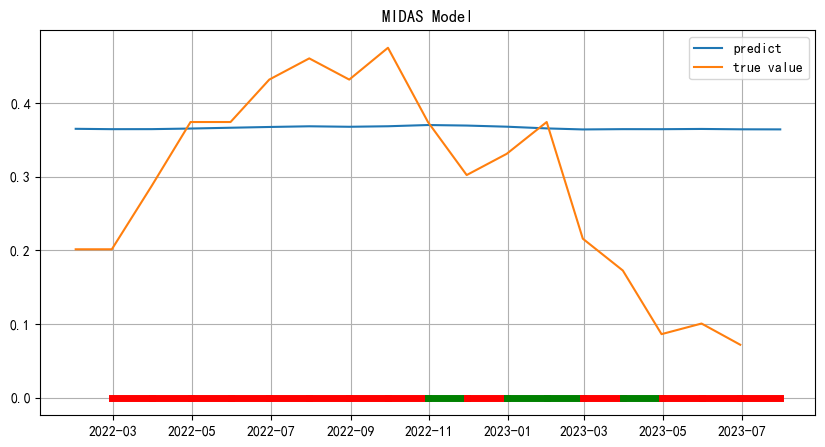

In [114]:
#参数估计
"""
lf_data: 低频数据。
x_train: 高频数据的训练集。
lf_data_lag: 低频数据的滞后值。
"""
opt_res = estimate3(lf_data_train,x_train,lf_data_lag_train,'ridge')#
#预测
"""
x_test: 高频数据的测试集。
lf_data_lag: 低频数据的滞后值。
opt_res: 优化结果。
"""
pre_yl = forcast3(x_test,lf_data_lag_test,opt_res,lf_data_test)
analyse3(pre_yl,lf_data_test)


胜率为：66.67%


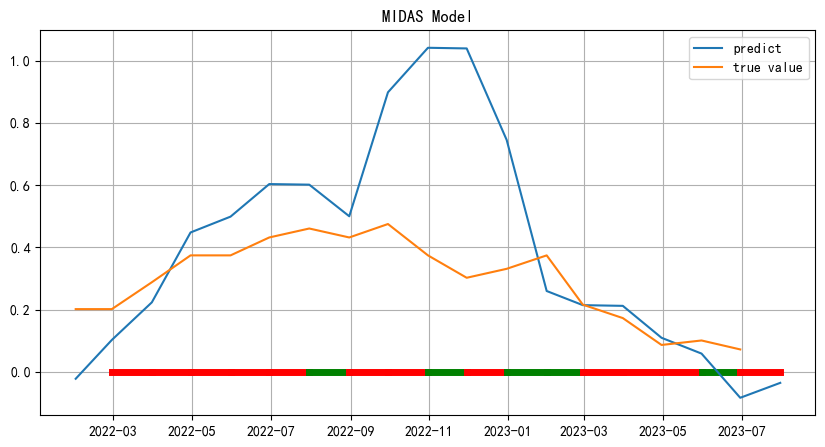

In [88]:
#参数估计
"""
lf_data: 低频数据。
x_train: 高频数据的训练集。
lf_data_lag: 低频数据的滞后值。
"""
opt_res = estimate3(lf_data_train,x_train,lf_data_lag_train,'muti_factor')#
#预测
"""
x_test: 高频数据的测试集。
lf_data_lag: 低频数据的滞后值。
opt_res: 优化结果。
"""
pre_yl = forcast3(x_test,lf_data_lag_test,opt_res,lf_data_test)
analyse3(pre_yl,lf_data_test)

横坐标的绿\红色代表趋势预测的错误\正确。


根据趋势线，我们选择相信cpi将会在7月有一个下降的趋势

而通过刚发布的7月的CPI环比数据为-0.3，确实下降了

接下来我们生成滚动预测的趋势预测图

100%|██████████| 19/19 [00:35<00:00,  1.89s/it]


胜率为：70.59%


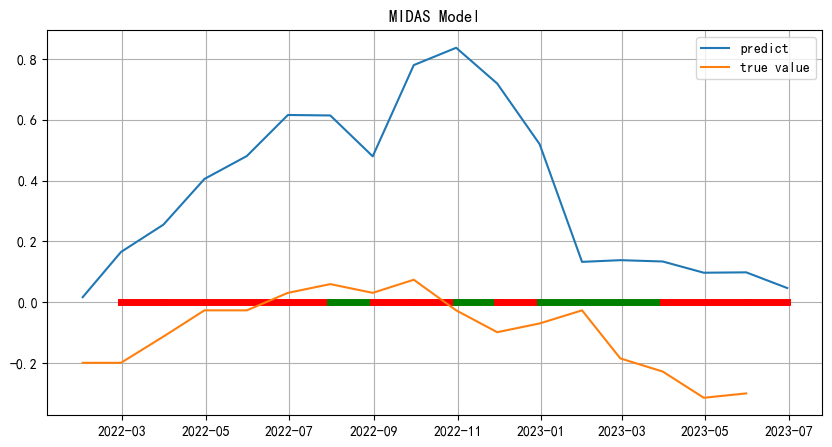

In [108]:
predict_res = pd.Series([])
for i in tqdm(range(1,20)):#建议设置滚动时，数量设置为为数据比较完整部分（本例为60），因为可能有的高频数据不完整，会没有预测结果
    lf_data_train,lf_data_lag_train,x_train,lf_data_test,lf_data_lag_test,x_test = mix_freq3(df, xlag_list = [1,21,21,4,21],ylag = 0, test_start_position_rate = i)
    opt_res = estimate3(lf_data_train,x_train,lf_data_lag_train,'ridge')
    predict_tmp = forcast3(x_test,lf_data_lag_test,opt_res,lf_data_test)
    predict_res = predict_res.combine_first(predict_tmp)
analyse3(predict_res,df.iloc[:,0].dropna())

100%|██████████| 19/19 [00:29<00:00,  1.57s/it]


胜率为：76.47%


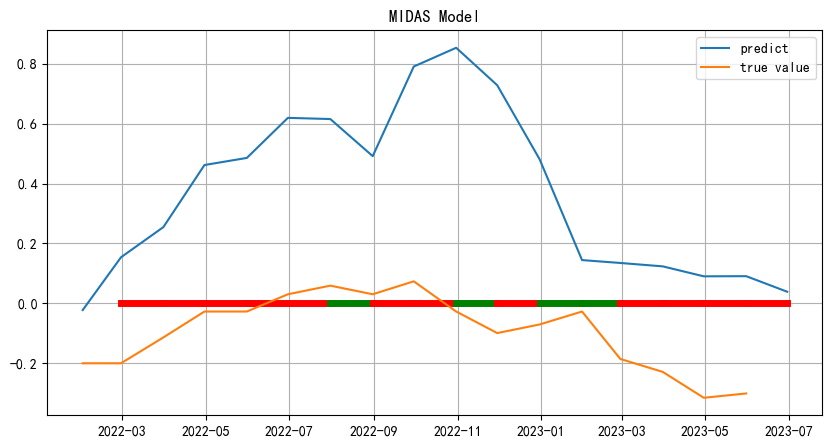

In [75]:
predict_res = pd.Series([])
for i in tqdm(range(1,20)):#建议设置滚动时，数量设置为为数据比较完整部分（本例为60），因为可能有的高频数据不完整，会没有预测结果
    lf_data_train,lf_data_lag_train,x_train,lf_data_test,lf_data_lag_test,x_test = mix_freq3(df, xlag_list = [1,21,21,4,21],ylag = 0, test_start_position_rate = i)
    opt_res = estimate3(lf_data_train,x_train,lf_data_lag_train)
    predict_tmp = forcast3(x_test,lf_data_lag_test,opt_res,lf_data_test)
    predict_res = predict_res.combine_first(predict_tmp)
analyse3(predict_res,df.iloc[:,0].dropna())

In [113]:
from scipy.optimize import least_squares
def estimate3(lf_data_train,x_train,lf_data_lag_train,model='muti_factor'):
    yx_df = [np.ones(len(lf_data_train))]
    for x in x_train:
        weight_method = polynomial_weights("expalmon")
        xw, w = weight_method.x_weighted(x, weight_method.init_params())
        yx_df.append(xw)
    yx_df = pd.DataFrame(data=yx_df).T
    #将xw_df的index设置为lf_data_train的index
    yx_df.index = lf_data_train.index
    #为wx_df增加lf_data_lag_train，注意lf_data_lag_train是个dataframe
    yx_df = pd.concat([yx_df,lf_data_lag_train],axis=1)

    c = np.linalg.lstsq(yx_df, lf_data_train,rcond=None)[0]
    a_ = [0,-1]*len(x_train)
    a_.extend(c)
    f = lambda v: ssr3(v, lf_data_train, x_train,lf_data_lag_train,model)
    opt_res = least_squares(f,
                            a_,

                            xtol=1e-5,
                            ftol=1e-5,
                            max_nfev=3000,
                            verbose=0
    )
 
    return opt_res

def ssr3(a, lf_data_train, x_train,lf_data_lag_train,model):

    yx_df_ = [np.ones(len(lf_data_train))]
    for x_index in range(len(x_train)):
        weight_method = polynomial_weights("expalmon")
        xw, w = weight_method.x_weighted(x_train[x_index], (a[2*x_index],a[2*x_index+1]))
        yx_df_.append(xw)
    yx_df_ = pd.DataFrame(data=yx_df_).T
    #将xw_df的index设置为lf_data_train的index
    yx_df_.index = lf_data_train.index
    #为wx_df增加lf_data_lag_train，注意lf_data_lag_train是个dataframe
    yx_df_2 = pd.concat([yx_df_,lf_data_lag_train],axis=1)
    vector = np.array(a[2*len(x_train):]).reshape(-1, 1)
    error = list(lf_data_train - np.dot(yx_df_2, vector).reshape(-1))
    if model == 'ridge':
        error.extend(vector[1:].reshape(-1)*10)
    elif model == 'muti_factor':
        pass

    return error

In [ ]:
#对vector[1:].reshape(-1)的每个值求sqrt
#